<a href="https://colab.research.google.com/github/maki8maki/GCI2023Winter/blob/main/competition1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install pycaret
!pip install optuna

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
path = "/content/drive/My Drive/Colab Notebooks/GCI2023Winter/competition1/"

df = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

以下のサイトを参考にした

https://qiita.com/jun40vn/items/d8a1f71fae680589e05c

# EDA

In [ ]:
df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: xlabel='Cabin_label', ylabel='Perished'>

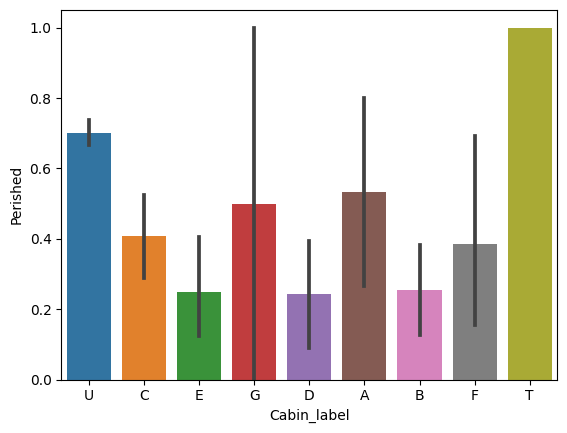

In [ ]:
# Cabinについて
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0) # 先頭の文字が同じ＝船室が近いと判断
sns.barplot(x='Cabin_label', y='Perished', data=df)

# Unnownの生存率が低い

<Axes: xlabel='Embarked', ylabel='count'>

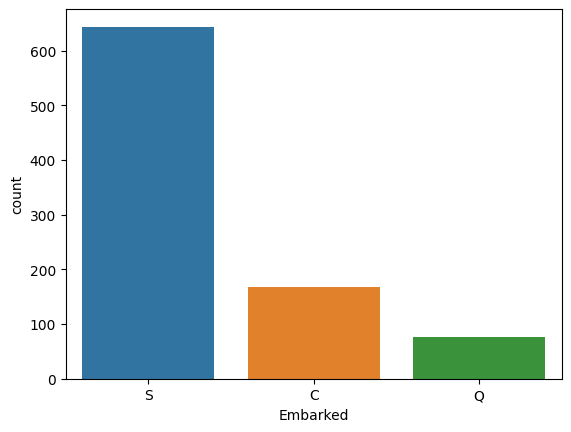

In [ ]:
sns.countplot(x='Embarked',data=df)

# 欠損値はSで埋める

<Axes: xlabel='Title', ylabel='Perished'>

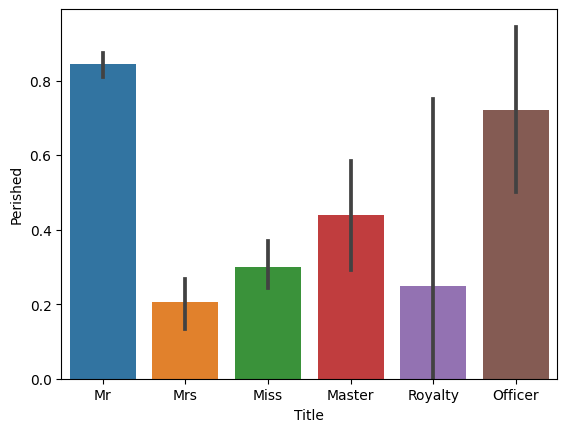

In [ ]:
# 名前から敬称を取り出し，グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Perished', data=df)

<Axes: xlabel='TicketGroup', ylabel='Perished'>

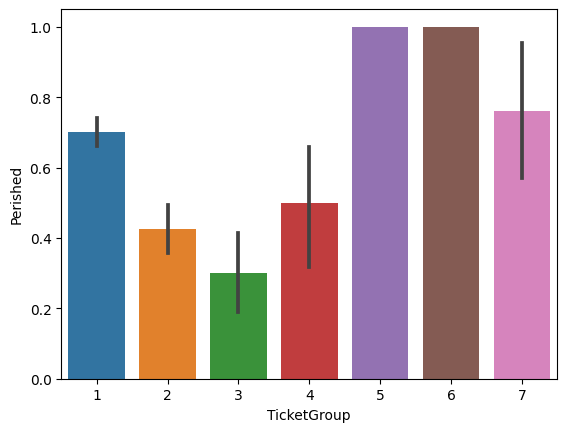

In [ ]:
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Perished', data=df)

0.000000    77
1.000000    27
0.250000     2
0.500000     1
0.666667     1
0.857143     1
Name: Perished, dtype: int64
1.000000    70
0.000000    14
0.500000     4
0.666667     1
Name: Perished, dtype: int64
{'Cacic', 'Vander Planke', 'Rosblom', 'Strom', 'Palsson', 'Bourke', 'Elias', 'Rice', 'Lobb', 'Boulos', 'Van Impe', 'Danbom', 'Johnston', 'Goodwin', 'Skoog', 'Olsson', 'Attalah', 'Arnold-Franchi', 'Jussila', 'Zabour', 'Ford', 'Oreskovic', 'Panula', 'Lefebre', 'Turpin', 'Barbara', 'Sage'}
{'Beane', 'Daly', 'Frauenthal', 'Duff Gordon', 'Jussila', 'Chambers', 'Dick', 'Hoyt', 'Flynn', 'Nakid', 'Taylor', 'Goldenberg', 'Bishop', 'Beckwith'}


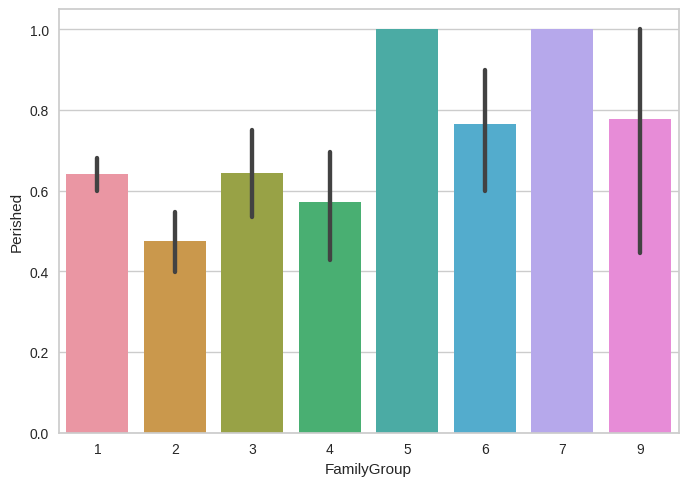

In [ ]:
# 同じ苗字＝家族
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts())
sns.barplot(x='FamilyGroup', y='Perished', data=df)


Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_List=Female_Child_Group.groupby('Surname')['Perished'].mean()
print(Female_Child_List.value_counts())

Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Perished'].mean()
print(Male_Adult_List.value_counts())

Dead_list=set(Female_Child_List[Female_Child_List.apply(lambda x:x==1)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==0)].index)
print(Dead_list)
print(Survived_list)

# Ageの欠損値補完の検討

In [4]:
from pycaret import regression
df = pd.read_csv(path + 'data/train.csv')
df['Family'] = df['SibSp'] + df['Parch']
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
age_df = df[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Family']]

known_age = age_df[age_df['Age'].notnull()]

exp_age = regression.setup(known_age, target='Age', session_id=0, normalize=True)

,Description,Value
0,Session id,0
1,Target,Age
2,Target type,Regression
3,Original data shape,"(714, 6)"
4,Transformed data shape,"(714, 6)"
5,Transformed train set shape,"(499, 6)"
6,Transformed test set shape,"(215, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [5]:
regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,9.5709,150.4427,12.1329,0.2713,0.5711,0.8765,0.1320
ada,AdaBoost Regressor,9.8432,150.9488,12.2026,0.2645,0.5913,1.0021,0.0870
lightgbm,Light Gradient Boosting Machine,9.7517,155.2557,12.3156,0.2502,0.5800,0.8939,0.5320
rf,Random Forest Regressor,9.8840,161.8238,12.5846,0.2156,0.5966,0.8972,0.5780
et,Extra Trees Regressor,10.0350,168.1111,12.8425,0.1828,0.6328,0.9214,0.3190
knn,K Neighbors Regressor,10.1809,168.8220,12.8433,0.1806,0.5833,0.8596,0.1210
xgboost,Extreme Gradient Boosting,10.0697,169.5004,12.8965,0.1739,0.6333,0.9212,0.1020
br,Bayesian Ridge,10.1678,168.5499,12.9249,0.1721,0.6253,1.1238,0.0480
dt,Decision Tree Regressor,10.0401,169.6632,12.9068,0.1720,0.6335,0.9164,0.1090
lr,Linear Regression,10.1364,168.5909,12.9257,0.1720,0.6258,1.1201,1.0470


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=0)

In [6]:
gbr = regression.create_model('gbr')
tuned_gbr = regression.tune_model(gbr, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.4957,145.5034,12.0625,0.2107,0.5541,0.6910
1,7.0867,76.2440,8.7318,0.5247,0.3741,0.4024
2,11.9874,232.8806,15.2604,0.0448,0.6601,1.1982
3,8.5378,120.4999,10.9772,0.4066,0.5797,0.8938
4,8.6924,107.1736,10.3525,0.3236,0.6431,1.4373
5,9.1795,147.6871,12.1527,0.3039,0.6047,1.0442
6,10.4802,170.1584,13.0445,0.2904,0.6476,1.0936
7,9.6066,152.1924,12.3366,0.2841,0.4901,0.5273
8,10.8090,210.1055,14.4950,0.2064,0.5681,0.7535


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.2787,133.4418,11.5517,0.2761,0.5590,0.7196
1,7.1814,78.1928,8.8427,0.5126,0.3813,0.4130
2,12.0987,236.9376,15.3928,0.0282,0.6644,1.2070
3,8.3663,115.3562,10.7404,0.4320,0.5703,0.8864
4,8.2721,97.2206,9.8601,0.3865,0.6076,1.2670
5,9.2386,144.9014,12.0375,0.3171,0.5702,0.8735
6,10.7290,175.0709,13.2314,0.2699,0.6577,1.1277
7,9.6894,152.1399,12.3345,0.2844,0.4942,0.5346
8,10.3876,198.3048,14.0821,0.2510,0.5087,0.6556


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [7]:
final_gbr = regression.finalize_model(tuned_gbr)

# モデル選択

## ベースライン

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

df['Age'].fillna(df['Age'].mean(), inplace=True)
df_test['Age'].fillna(df['Age'].mean(), inplace=True)

df['Fare'].fillna(df['Fare'].mean(), inplace=True)
df_test['Fare'].fillna(df['Fare'].mean(), inplace=True)

df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
df_test.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

df['Family'] = df['SibSp'] + df['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_test = df_test.iloc[:, :].values

param_grid = {'max_depth': [3, 5, 7],
              'min_samples_leaf': [1, 2, 4]}
rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(X, y)
print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1}
CV Score: 0.826


# 提出用処理

## データの前処理

In [12]:
from pycaret import regression
from sklearn.preprocessing import StandardScaler

df_train = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')
df_test['Perished'] = np.nan
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)
train_size = df_train.shape[0]

# Embarkedは最頻値で補完
df['Embarked'].fillna('S', inplace=True)

# 家族の数を新たに追加
df['Family'] = df['SibSp'] + df['Parch']

# 名前から敬称を取り出し，グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)

# 名字の抽出、同じ苗字の人を数える
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())
df['FamilyGroup'] = df['Surname'].map(df.iloc[:train_size]['Surname'].value_counts())
def familygroup2label(x):
    if x in [5, 7]:
        return 0
    elif x in[6, 9]:
        return 1
    else:
        return 2
df['FamilyLabel'] = df['FamilyGroup'].map(familygroup2label)

# 女性子供の家族
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_List=Female_Child_Group.groupby('Surname')['Perished'].mean()

# 成人男性の家族
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Perished'].mean()

# 生存・死亡リストの適用
Dead_list=set(Female_Child_List[Female_Child_List.apply(lambda x:x==1)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==0)].index)
df.loc[(df['Perished'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)), ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Perished'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)), ['Sex','Age','Title']] = ['female',5.0,'Mrs']

# 性別の数値化
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

# Cabinの欠損値補完と1文字目の取り出し
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0) # 先頭の文字が同じ＝同じグループと判断

# Fareの欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

# Ageの欠損値補完
age_df = df[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Family']]
unknown_age = age_df[age_df['Age'].isnull()].drop(['Age'], axis=1)
predicted_age = regression.predict_model(final_gbr, data=unknown_age)
df.loc[(df['Age'].isnull()), 'Age'] = predicted_age.loc[:, 'prediction_label']

# 同じチケットの人数を利用（人数は訓練データからのみ得る）
Ticket_Count = dict(df.iloc[:train_size]['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
def ticketgroup2label(x):
    if x in [5, 6]:
        return 0
    elif x in[1, 7]:
        return 1
    else:
        return 2
df['TicketLabel'] = df['TicketGroup'].map(ticketgroup2label)

# 使わない特徴量の削除
drop_list = ['Cabin', 'Name', 'PassengerId', 'Ticket', 'TicketGroup', 'Surname', 'FamilyGroup']
df.drop(drop_list, axis=1, inplace=True)

# カテゴリカル変数をone-hot表現にする
df['Pclass'] = df['Pclass'].astype(object)
df['TicketLabel'] = df['TicketLabel'].astype(object)
df['FamilyLabel'] = df['FamilyLabel'].astype(object)
df = pd.get_dummies(df)

# 数値データの正規化
sc = StandardScaler()
sc_list = ['Age', 'Fare', 'SibSp', 'Parch', 'Family']
sc.fit(df.loc[:train_size, sc_list])
df.loc[:, sc_list] = sc.transform(df.loc[:, sc_list])

print(df.columns)
df.head()

Index(['Perished', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'FamilyLabel_0', 'FamilyLabel_1',
       'FamilyLabel_2', 'Cabin_label_A', 'Cabin_label_B', 'Cabin_label_C',
       'Cabin_label_D', 'Cabin_label_E', 'Cabin_label_F', 'Cabin_label_G',
       'Cabin_label_T', 'Cabin_label_U', 'TicketLabel_0', 'TicketLabel_1',
       'TicketLabel_2'],
      dtype='object')


,Perished,Sex,Age,SibSp,Parch,Fare,Family,Pclass_1,Pclass_2,Pclass_3,...,Cabin_label_C,Cabin_label_D,Cabin_label_E,Cabin_label_F,Cabin_label_G,Cabin_label_T,Cabin_label_U,TicketLabel_0,TicketLabel_1,TicketLabel_2
0,1.0,0,-0.561512,0.433514,-0.473348,-0.502109,0.059812,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0.0,1,0.626375,0.433514,-0.473348,0.787731,0.059812,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.0,1,-0.264540,-0.474219,-0.473348,-0.488512,-0.560561,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,0.0,1,0.403646,0.433514,-0.473348,0.421460,0.059812,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1.0,0,0.403646,-0.474219,-0.473348,-0.485994,-0.560561,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データセットの読み込み
df_train = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

# train_dataとtest_dataの連結
df_test['Perished'] = np.nan
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges

# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)

# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts())

# 家族で16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Perished'].mean()

# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Perished'].mean()

# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==1)].index)
Perished_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==0)].index)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Perished'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)), ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Perished'].isnull()) & (df['Surname'].apply(lambda x:x in Perished_list)), ['Sex','Age','Title']] = ['female',5.0,'Mrs']

# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)

# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0

# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)

# ---------- Embarked ---------------
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S')

# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Perished','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Perished'].notnull()]
test = df[df['Perished'].isnull()].drop('Perished',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]
y = train.values[:,0]
test_x = test.values

mean_score =  0.8395006242197255
mean_std =  0.049770983038016456


In [23]:
# ----------- 推定モデル構築 ---------------
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold, cross_val_score
import lightgbm as lgb

seed = 0
X_cv, X_eval, y_cv, y_eval = train_test_split(X, y, test_size=0.25, random_state=seed)

# 採用する特徴量を20個に絞り込む
select = SelectKBest(k = 20)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'early_stopping_round': 100,
    'random_state': seed,
    'verbose': -1,
}
fit_params = {
    'lgbmclassifier__eval_set': [(X_eval, y_eval)]
}
clf = lgb.LGBMClassifier(**params)
pipeline = make_pipeline(select, clf)

cv = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = 'accuracy'
scores = cross_val_score(pipeline, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=-1, fit_params=fit_params)

print(np.mean(scores))

0.6884893713251923


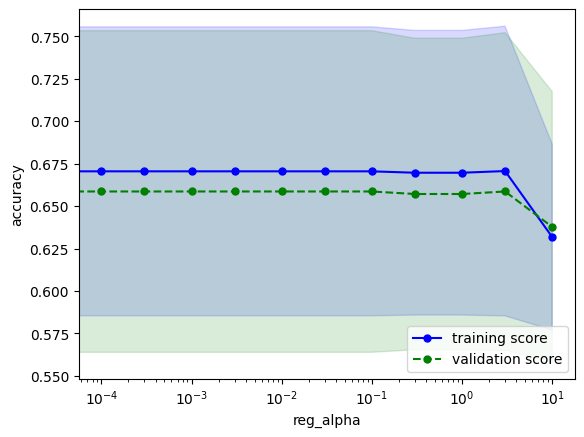

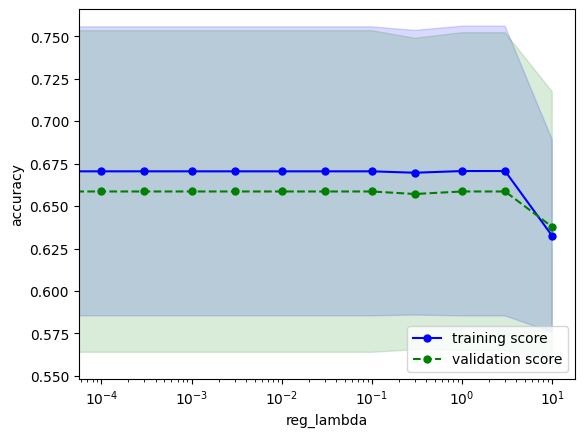

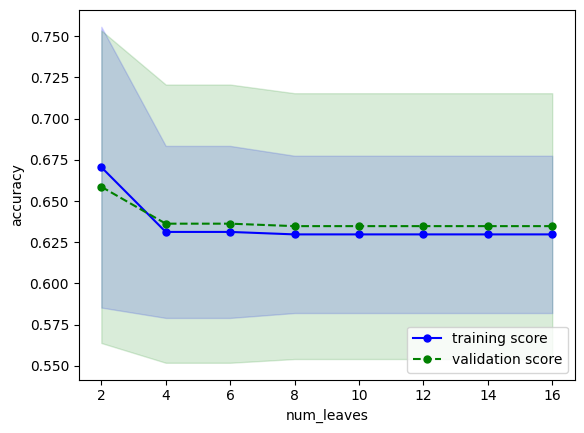

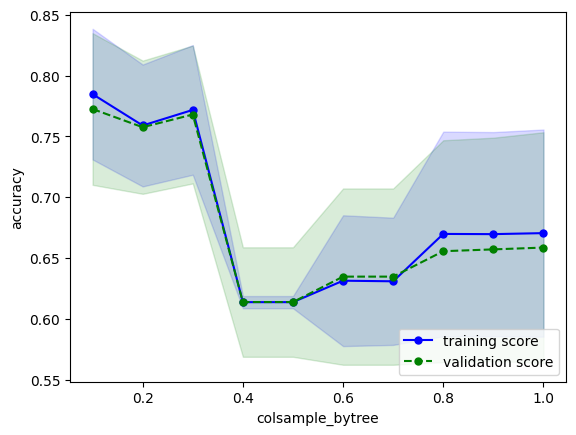

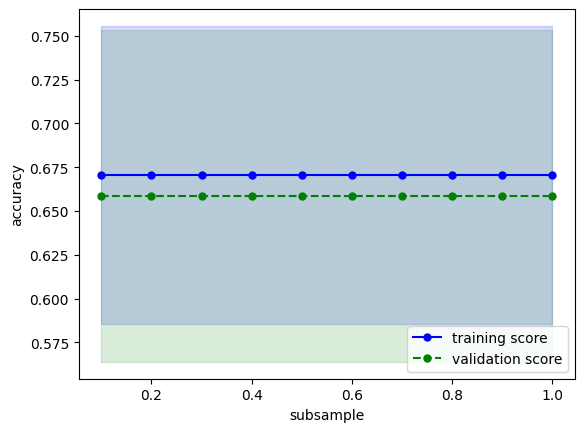

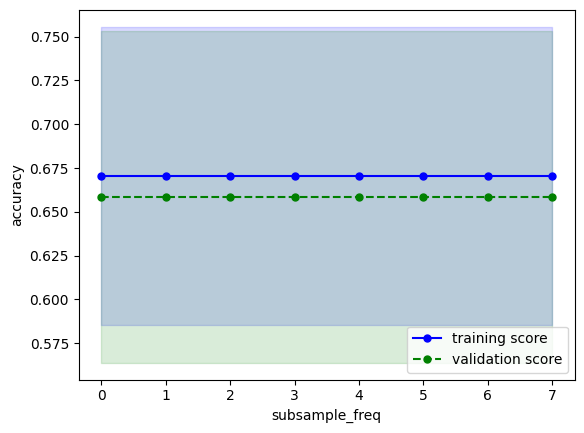

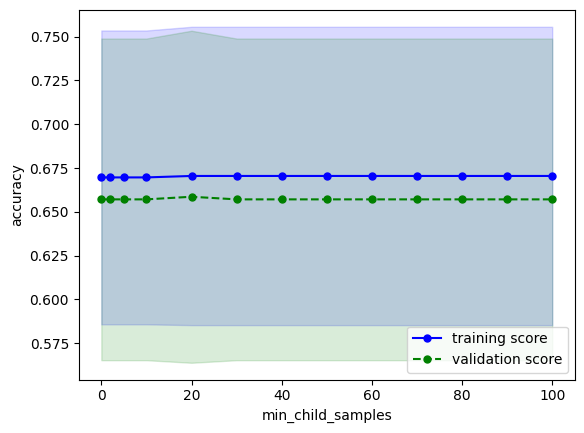

In [19]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 6, 8, 10, 12, 14, 16],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
pipeline.set_params(lgbmclassifier__num_leaves=2)
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=pipeline, X=X_cv, y=y_cv,
                                                  param_name='lgbmclassifier__'+k, param_range=v,
                                                  fit_params=fit_params, cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

In [24]:
import optuna

def bayes_objective(trial):
    params = {
        'lgbmclassifier__reg_alpha': trial.suggest_float('lgbmclassifier__reg_alpha', 0.0001, 3, log=True),
        'lgbmclassifier__reg_lambda': trial.suggest_float('lgbmclassifier__reg_lambda', 0.0001, 3, log=True),
        'lgbmclassifier__num_leaves': trial.suggest_int('lgbmclassifier__num_leaves', 2, 6),
        'lgbmclassifier__colsample_bytree': trial.suggest_float('lgbmclassifier__colsample_bytree', 0.0, 0.4),
        'lgbmclassifier__subsample': trial.suggest_float('lgbmclassifier__subsample', 0.0, 1.0),
        'lgbmclassifier__subsample_freq': trial.suggest_int('lgbmclassifier__subsample_freq', 0, 7),
        'lgbmclassifier__min_child_samples': trial.suggest_int('lgbmclassifier__min_child_samples', 0, 100)
    }
    # モデルにパラメータ適用
    pipeline.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')

[I 2023-11-20 04:22:02,151] A new study created in memory with name: no-name-b87f12db-5236-4649-8e8a-4a455cdfe5b8
[I 2023-11-20 04:22:02,556] Trial 0 finished with value: 0.7218352059925095 and parameters: {'lgbmclassifier__reg_alpha': 0.028648679132350478, 'lgbmclassifier__reg_lambda': 0.15921702813468602, 'lgbmclassifier__num_leaves': 5, 'lgbmclassifier__colsample_bytree': 0.21795327319875876, 'lgbmclassifier__subsample': 0.4236547993389047, 'lgbmclassifier__subsample_freq': 5, 'lgbmclassifier__min_child_samples': 44}. Best is trial 0 with value: 0.7218352059925095.
[I 2023-11-20 04:22:02,971] Trial 1 finished with value: 0.778876404494382 and parameters: {'lgbmclassifier__reg_alpha': 0.9830505628509638, 'lgbmclassifier__reg_lambda': 2.062695054955601, 'lgbmclassifier__num_leaves': 3, 'lgbmclassifier__colsample_bytree': 0.31669001523306584, 'lgbmclassifier__subsample': 0.5288949197529045, 'lgbmclassifier__subsample_freq': 4, 'lgbmclassifier__min_child_samples': 93}. Best is trial 1 w

最適パラメータ {'lgbmclassifier__reg_alpha': 0.00016802755690881204, 'lgbmclassifier__reg_lambda': 0.004482329068040228, 'lgbmclassifier__num_leaves': 6, 'lgbmclassifier__colsample_bytree': 0.3990891437513195, 'lgbmclassifier__subsample': 0.9805186742084687, 'lgbmclassifier__subsample_freq': 7, 'lgbmclassifier__min_child_samples': 4}
スコア 0.832721598002497


In [25]:
pipeline.set_params(**best_params)

Pipeline(steps=[('selectkbest', SelectKBest(k=20)),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.3990891437513195,
                                early_stopping_round=100,
                                metric='binary_logloss', min_child_samples=4,
                                n_estimators=1000, num_leaves=6,
                                objective='binary', random_state=0,
                                reg_alpha=0.00016802755690881204,
                                reg_lambda=0.004482329068040228,
                                subsample=0.9805186742084687, subsample_freq=7,
                                verbose=-1))])

## 推定

In [13]:
from pycaret import classification
train = df.iloc[:train_size]
test = df.iloc[train_size:].drop('Perished', axis=1)

exp_perished = classification.setup(train, target='Perished', session_id=0, feature_selection=True, n_features_to_select=20,
                                    feature_selection_method='univariate')

,Description,Value
0,Session id,0
1,Target,Perished
2,Target type,Binary
3,Original data shape,"(891, 34)"
4,Transformed data shape,"(891, 21)"
5,Transformed train set shape,"(623, 21)"
6,Transformed test set shape,"(268, 21)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


In [14]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8234,0.8692,0.8853,0.8381,0.8607,0.6197,0.6226,0.1520
lightgbm,Light Gradient Boosting Machine,0.8169,0.8689,0.8776,0.8354,0.8556,0.6059,0.6083,0.7240
xgboost,Extreme Gradient Boosting,0.8153,0.8638,0.8750,0.8358,0.8543,0.6021,0.6049,0.0950
lda,Linear Discriminant Analysis,0.8089,0.8639,0.8617,0.8340,0.8469,0.5922,0.5948,0.0460
ridge,Ridge Classifier,0.8073,0.0000,0.8617,0.8319,0.8459,0.5884,0.5910,0.0830
lr,Logistic Regression,0.8056,0.8640,0.8540,0.8354,0.8438,0.5861,0.5882,0.7670
knn,K Neighbors Classifier,0.8026,0.8468,0.8831,0.8172,0.8470,0.5696,0.5783,0.0940
ada,Ada Boost Classifier,0.7993,0.8572,0.8412,0.8375,0.8378,0.5741,0.5776,0.1490
rf,Random Forest Classifier,0.7785,0.8555,0.8386,0.8096,0.8230,0.5265,0.5291,0.4240
svm,SVM - Linear Kernel,0.7754,0.0000,0.8535,0.7997,0.8230,0.5134,0.5232,0.0690


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [15]:
gbc = classification.create_model('gbc')
tuned_gbc = classification.tune_model(gbc, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8141,0.8974,0.7778,0.8333,0.5051,0.5168
1,0.8413,0.8713,0.8974,0.8537,0.8750,0.6580,0.6595
2,0.8730,0.9605,0.8974,0.8974,0.8974,0.7308,0.7308
3,0.8387,0.8880,0.8974,0.8537,0.8750,0.6481,0.6497
4,0.8871,0.8805,0.9474,0.8780,0.9114,0.7565,0.7606
5,0.7742,0.8520,0.8421,0.8000,0.8205,0.5167,0.5179
6,0.7742,0.8103,0.8421,0.8000,0.8205,0.5167,0.5179
7,0.7903,0.8213,0.8158,0.8378,0.8267,0.5615,0.5618
8,0.8548,0.9375,0.9211,0.8537,0.8861,0.6869,0.6906


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8200,0.9231,0.8000,0.8571,0.5758,0.5892
1,0.8413,0.8766,0.9231,0.8372,0.8780,0.6523,0.6587
2,0.9048,0.9541,0.8974,0.9459,0.9211,0.8013,0.8030
3,0.8065,0.8802,0.8718,0.8293,0.8500,0.5778,0.5792
4,0.8871,0.8838,0.9737,0.8605,0.9136,0.7526,0.7646
5,0.8065,0.8766,0.8947,0.8095,0.8500,0.5792,0.5850
6,0.7742,0.8048,0.8947,0.7727,0.8293,0.5011,0.5130
7,0.8548,0.8575,0.8947,0.8718,0.8831,0.6917,0.6921
8,0.8871,0.9397,0.9211,0.8974,0.9091,0.7602,0.7607


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [16]:
lgbm = classification.create_model('lightgbm')
tuned_lgbm = classification.tune_model(lgbm, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8392,0.8718,0.7907,0.8293,0.5132,0.5183
1,0.8571,0.8584,0.9231,0.8571,0.8889,0.6897,0.6934
2,0.8571,0.9530,0.8718,0.8947,0.8831,0.6995,0.6999
3,0.7742,0.8144,0.8462,0.8049,0.8250,0.5074,0.5086
4,0.8548,0.8750,0.8947,0.8718,0.8831,0.6917,0.6921
5,0.7742,0.8317,0.8421,0.8000,0.8205,0.5167,0.5179
6,0.8065,0.8185,0.8947,0.8095,0.8500,0.5792,0.5850
7,0.7903,0.8706,0.8421,0.8205,0.8312,0.5547,0.5550
8,0.8710,0.9507,0.8947,0.8947,0.8947,0.7281,0.7281


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8248,0.8718,0.8095,0.8395,0.5517,0.5547
1,0.8730,0.8958,0.9231,0.8780,0.9000,0.7264,0.7281
2,0.8730,0.9188,0.8462,0.9429,0.8919,0.7391,0.7455
3,0.7742,0.8233,0.7949,0.8378,0.8158,0.5246,0.5259
4,0.8871,0.8772,0.9474,0.8780,0.9114,0.7565,0.7606
5,0.8226,0.8690,0.9474,0.8000,0.8675,0.6049,0.6249
6,0.7742,0.8317,0.8421,0.8000,0.8205,0.5167,0.5179
7,0.8548,0.9002,0.8947,0.8718,0.8831,0.6917,0.6921
8,0.9032,0.9507,0.9474,0.9000,0.9231,0.7929,0.7948


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [30]:
# final_lgbm = classification.finalize_model(tuned_lgbm)
# pred = classification.predict_model(final_lgbm, data=test).loc[:, 'prediction_label'].values
pipeline.fit(X, y, lgbmclassifier__eval_set=[(X, y)])
pred = pipeline.predict(test_x).astype(np.int32)
pred[:5]

array([1, 0, 1, 1, 0], dtype=int32)

In [31]:
submission = pd.read_csv(path + 'gender_submission.csv')
submission

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [32]:
submission['Perished'] = pred
submission.iloc[:9]

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
5,897,1
6,898,0
7,899,1
8,900,0


In [33]:
submission.to_csv(path+'submission.csv', index=False)